In [1]:
# Data Sience course final project
# The goal of the project is to find a function that best reflects the course of power demand in the KSEE under the situation of normal operation of the KSEE.
# For this purpose, we will use daily and hourly dataset for a period of 1 month (July 2022)
# data source : www.pse.pl (daily reports of working KSEE)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates

In [3]:
# import dataset from .csv

In [4]:
URL = 'InputData/data_actual_total_load_less.csv'

In [5]:
df = pd.read_csv(URL, sep = ';')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Actual Total Load  744 non-null    object
 1   Date               744 non-null    int64 
 2   Hour               744 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 17.6+ KB


In [7]:
# The raw data consists of 3 columns, of which the column 'actual total load' is of type 'object' - we need to convert it to type 'float'.
# In addition, we will create a new column 'DateTime', which will be a combination of columns 'date' and 'hour' and converted to type 'datetime64'

In [8]:
df['DateTime'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df['DateTime'] = df['DateTime'] + pd.to_timedelta(df['Hour'], unit='h')

In [10]:
df['Actual Total Load'] = df['Actual Total Load'].str.replace(',', '.').astype(float)


In [11]:
df.drop(['Date'], axis=1, inplace=True)

In [12]:
# Creatin new columns for train/test values for KNN, Decision Tree, XGBoost, LSTM

In [13]:
features = ["year", "month", "day"]

In [14]:
df[features] = df.apply(lambda row: pd.Series({"year":row.DateTime.year, "month":row.DateTime.month, "day":row.DateTime.day}), axis=1)

In [15]:
# Creating new DF with only 2 columns. Index column set to DateTime
df2 = df[["Actual Total Load","DateTime"]]

In [16]:
df2.set_index(["DateTime"], inplace = True)

In [17]:
df2

,Actual Total Load
DateTime,
2022-07-01 01:00:00,18099.675
2022-07-01 02:00:00,17380.988
2022-07-01 03:00:00,16981.163
2022-07-01 04:00:00,16783.225
2022-07-01 05:00:00,16507.000
...,...
2022-07-31 20:00:00,16722.288
2022-07-31 21:00:00,17016.050
2022-07-31 22:00:00,17146.688


In [114]:
# Split data into train-test
# ==============================================================================
end_train = 575

# 'X' only for SARIMAX model
X = df['DateTime']
# 'x' for the rest alghoritms
x = df[["year", "month", "day","Hour"]]
Y = df['Actual Total Load']

X_train = X.iloc[:end_train]
X_test  = X.iloc[end_train:]
x_train = x.iloc[:end_train]
x_test  = x.iloc[end_train:]

Y_train = Y.iloc[:end_train]
Y_test  = Y.iloc[end_train:]

print(f"Train dates      : {df['DateTime'][0]} --- {df['DateTime'][end_train]}  (n={len(X_train)})")
print(f"Test dates       : {df['DateTime'][end_train+1]} --- {df['DateTime'][df['DateTime'].index.max()]}  (n={len(X_test)})")

Train dates      : 2022-07-01 01:00:00 --- 2022-07-25 00:00:00  (n=575)
Test dates       : 2022-07-25 01:00:00 --- 2022-08-01 00:00:00  (n=169)


In [19]:
# Chcecking sum of DataFrames :  train-test
# ==============================================================================

if len(df)==len(Y_train+Y_test):
    print('train + test   = df  (test ok)')
else :
    print('some datas are missing')       

train + test   = df  (test ok)


In [20]:
# proportion of train/test [%]
# ==============================================================================
len(Y_train)/len(df)*100

77.28494623655914

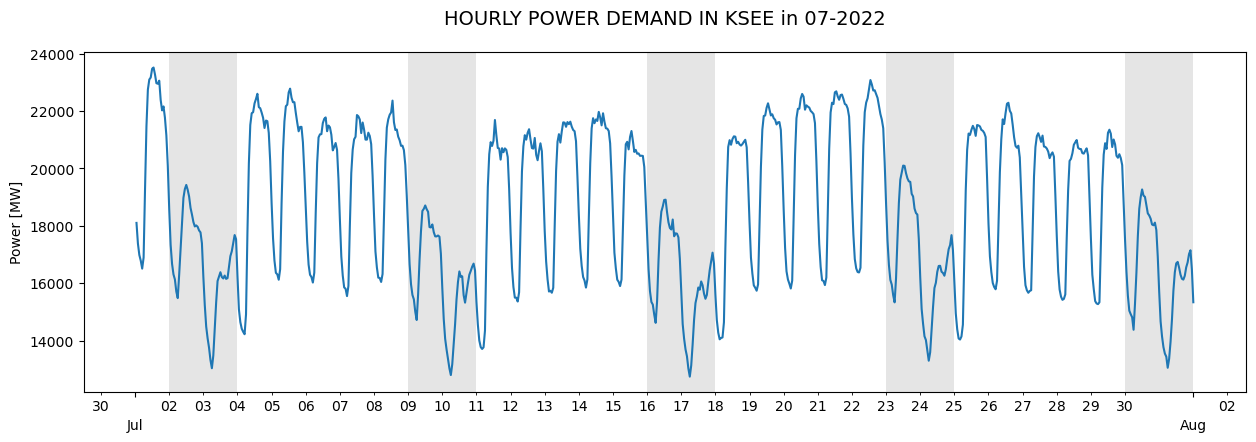

In [21]:
# Dataset visualisation 
# ==============================================================================

ax = df2.plot(x_compat=True, figsize=(15, 5), legend=None, ylabel='Power [MW]',xlabel = '')
ax.set_ylim(*ax.get_ylim())
xmin, xmax = ax.get_xlim()
days = np.arange(np.floor(xmin), np.ceil(xmax)+2)
weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor='k', alpha=.1)
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=np.arange(1, 31, step=1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%b'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.figure.autofmt_xdate(rotation=0, ha='center')
title = 'HOURLY POWER DEMAND IN KSEE in 07-2022'
ax.set_title(title, pad=20, fontsize=14);

In [22]:
# SARIMAX model
# ==============================================================================

In [23]:
# We will examine the stationarity feature of the time series according to the Dickey-Fuller method
# hypothesis 𝐻0 : no stationarity
# hypothesis 𝐻1 : there is stationarity
# if pvalue > 0.05 we accept the hypothesis H0, we reject H1

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
pvalue = adfuller(df2['Actual Total Load'])[1]

In [26]:
if pvalue > 0.05 :
    print('pvalue :  ' + str(pvalue)  +' - We accept the hypothesis H0, reject H1 - the series is non-stationary')
else :
    print('pvalue : ' + str(pvalue)  +' - We accept the hypothesis H1, reject H0 - the series is stationary')


pvalue :  0.4016928841682644 - We accept the hypothesis H0, reject H1 - the series is non-stationary


In [27]:
# Decomposition od dataset
# ==============================================================================

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df2['Actual Total Load'], model='additive')
trend_estimate = decomposition.trend
seasonal_estimate = decomposition.seasonal
residual_estimate = decomposition.resid

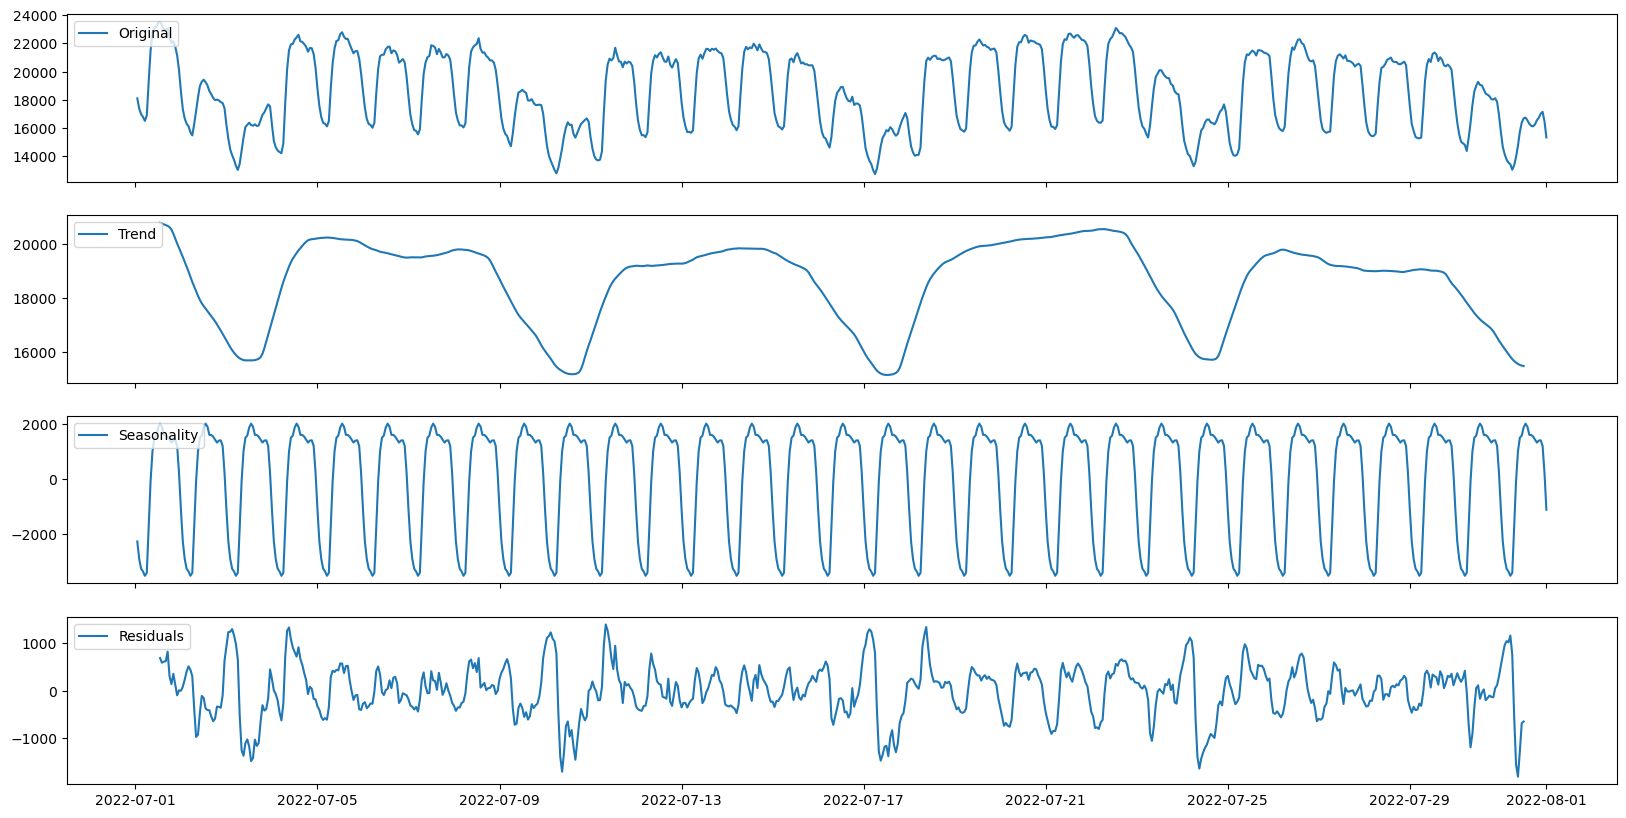

In [29]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 10))

axes[0].plot(df2['Actual Total Load'], label='Original') 
axes[0].legend(loc='upper left');

axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

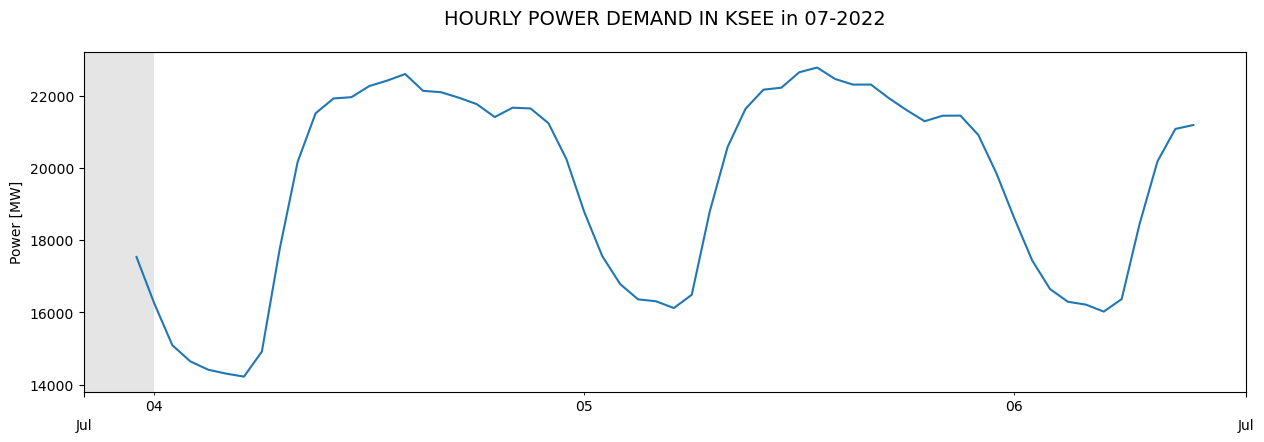

In [30]:
# Focus on seasionality 
# ==============================================================================
ax = df2[70:130].plot(x_compat=True, figsize=(15, 5), legend=None, ylabel='Power [MW]',xlabel = '')
ax.set_ylim(*ax.get_ylim())
xmin, xmax = ax.get_xlim()
days = np.arange(np.floor(xmin), np.ceil(xmax)+2)
weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor='k', alpha=.1)
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=np.arange(1, 31, step=1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%b'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.figure.autofmt_xdate(rotation=0, ha='center')
title = 'HOURLY POWER DEMAND IN KSEE in 07-2022'
ax.set_title(title, pad=20, fontsize=14);

In [31]:
# The presented hourly model of power demand in the KSEE is characterized by non-stationarity resulting from the 
# due to the pronounced seasonality of the data (power demand increases in the morning hours and decreases in the evening hours).
# It follows that the desired model reflecting the operating cycle of the KSEE will be a data model that takes into account 
# the seasonal factor (SARIMAX)


In [108]:
from pmdarima.arima import auto_arima

In [109]:
SARIMAX_model = auto_arima(y=Y_train,
                           exogenous=X,
                           m=24,
                           max_order=None,
                           max_p=24,
                           max_q=24,
                           max_d=2,
                           max_P=4,
                           max_Q=4,
                           max_D=2,
                           maxiter=100,
                           trace=True,
                           seasonal=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=8211.143, Time=7.73 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=10741.152, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=84.27 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=12955.427, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=8457.890, Time=2.35 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=8341.261, Time=4.52 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=97.84 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=8336.201, Time=75.52 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=8658.884, Time=0.18 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=8392.116, Time=20.17 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=8326.426, Time=83.08 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=95.20 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=7.92 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  575
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -4097.571
Date:                              Wed, 26 Jul 2023   AIC                           8211.143
Time:                                      17:43:51   BIC                           8245.978
Sample:                                           0   HQIC                          8224.729
                                              - 575                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    153.5984     46.741      3.286      0.001      61.987     245.209
ar.L1          0.3157      0.105      2.994      0.003       0.109       0.522
ar.L2          0.5911      0.103      5.749      0.000       0.390       0.793
ma.L1          1.2197      0.097     12.577      0.000       1.030       1.410
ma.L2          0.5013      0.046     10.913      0.000       0.411       0.591
ar.S.L24       0.9061      0.011     81.117      0.000       0.884       0.928
ma.S.L24      -0.4763      0.026    -18.429      0.000      -0.527      -0.426
sigma2      7.862e+04   3013.285     26.090      0.000    7.27e+04    8.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.90   Jarque-Bera (JB):               922.26
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
SARIMAX_model.order

(2, 0, 2)

In [111]:
SARIMAX_model.seasonal_order

(1, 0, 1, 24)

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [117]:
sarimax_model = SARIMAX(Y_train, order=SARIMAX_model.order, seasonal_order=SARIMAX_model.seasonal_order, enforce_stationarity=False)
# sarimax_model = SARIMAX(Y_train, order=(2, 0, 2), seasonal_order=(1, 0, 1, 24),)

fitted_model_sarimax = sarimax_model.fit()

pred_sarimax = fitted_model_sarimax.predict(len(Y_train), len(Y_train) + len(Y_test)-1)


C:\Users\pawel\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
# GridSearch for KNN
# ==============================================================================

In [40]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [41]:
parameters_KNN = {
    'n_neighbors': [1, 2, 3, 5, 10, 15, 20], 
    'metric': ['minkowski', 'cosine','manhattan','cityblock','l1','l2'], 
    'p': [1, 2]
                }

In [42]:
knn = neighbors.KNeighborsRegressor()
knn_model = GridSearchCV(estimator=knn, 
                   param_grid=parameters_KNN, 
                   cv=5)
knn_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['minkowski', 'cosine', 'manhattan',
                                    'cityblock', 'l1', 'l2'],
                         'n_neighbors': [1, 2, 3, 5, 10, 15, 20], 'p': [1, 2]})

In [43]:
knn_model.best_estimator_

KNeighborsRegressor(n_neighbors=15, p=1)

In [44]:
pred_KNN = knn_model.predict(x_test)

In [45]:
Y_train

0      18099.675
1      17380.988
2      16981.163
3      16783.225
4      16507.000
         ...    
570    16857.813
571    17183.438
572    17326.063
573    17673.538
574    17151.425
Name: Actual Total Load, Length: 575, dtype: float64

In [46]:
# GridSearch for Decision Tree
# ==============================================================================

In [47]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
parameters_dt = {
              "criterion": ['friedman_mse', 'squared_error', 'poisson'],
              "min_samples_split": [2, 3, 5, 10, 20, 40],
              "max_depth": [2, 6, 8, 10, 12],
              "min_samples_leaf": [10, 20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

In [49]:
dtr = DecisionTreeRegressor()
dt_model = GridSearchCV(estimator=dtr, 
                   param_grid=parameters_dt, 
                   cv=5,)

dt_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['friedman_mse', 'squared_error',
                                       'poisson'],
                         'max_depth': [2, 6, 8, 10, 12],
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [10, 20, 40, 100],
                         'min_samples_split': [2, 3, 5, 10, 20, 40]})

In [50]:
dt_model.best_estimator_

DecisionTreeRegressor(max_depth=2, max_leaf_nodes=5, min_samples_leaf=10,
                      min_samples_split=40)

In [51]:
pred_dt = dt_model.predict(x_test)

In [52]:
# GridSearch for XGBoost
# ==============================================================================

In [53]:
# pip install xgboost

In [54]:
from xgboost import XGBRegressor

In [55]:
parameters_xgb = {
        'learning_rate': [0.01, 0.1],   
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

In [56]:
xgb = XGBRegressor()
xgb_model = GridSearchCV(estimator=xgb, 
                   param_grid=parameters_xgb, 
                   cv=5,)

xgb_model.fit(x_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.5, 0.7]})

In [57]:
xgb_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [58]:
pred_xgb = xgb_model.predict(x_test)

In [59]:
# GridSearch for RandomForest
# ==============================================================================

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
parameters_rf = {
              "n_estimators": [10, 50, 100, 300, 500],
              "max_depth": [2, 5, 10, None]
             }

In [62]:
rf = RandomForestRegressor()
rf_model = GridSearchCV(estimator=rf, 
                   param_grid=parameters_rf, 
                   cv=5,)

rf_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10, None],
                         'n_estimators': [10, 50, 100, 300, 500]})

In [63]:
rf_model.best_estimator_

RandomForestRegressor(max_depth=2, n_estimators=10)

In [64]:
pred_rf = rf_model.predict(x_test)

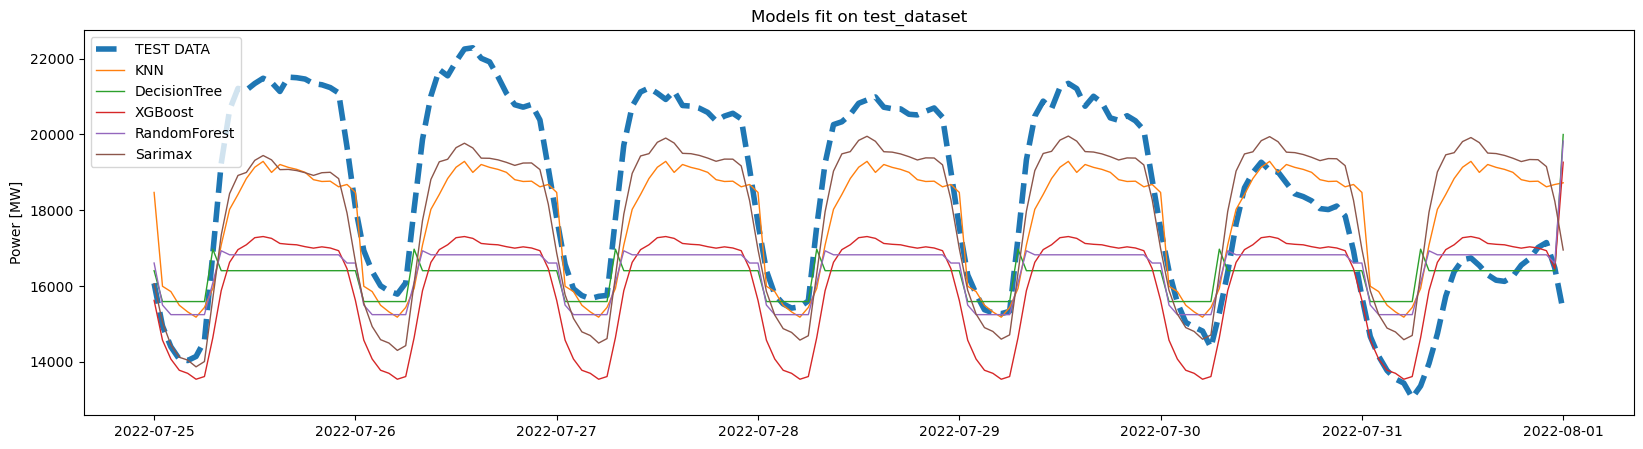

In [132]:
# Model visualisation
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(df['DateTime'][end_train:],Y_test, label='TEST DATA', linewidth=4, linestyle='dashed')
plt.plot(df['DateTime'][end_train:],pred_KNN, label='KNN', linewidth=1)
plt.plot(df['DateTime'][end_train:],pred_dt, label='DecisionTree', linewidth=1)
plt.plot(df['DateTime'][end_train:],pred_xgb, label='XGBoost', linewidth=1)
plt.plot(df['DateTime'][end_train:],pred_rf, label='RandomForest', linewidth=1)
plt.plot(df['DateTime'][end_train:],pred_sarimax, label='Sarimax', linewidth=1)
plt.title('Models fit on test_dataset')
plt.legend();
plt.ylabel('Power [MW]');

In [119]:
# error metrics
# ==============================================================================

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [121]:
Sarimax_ = round(mean_absolute_percentage_error(Y_test, pred_sarimax)*100,2)

In [122]:
DecissionTree_ = round(mean_absolute_percentage_error(Y_test, pred_dt)*100,2)

In [123]:
KNN_ = round(mean_absolute_percentage_error(Y_test, pred_KNN)*100,2)

In [124]:
XGBoost_ = round(mean_absolute_percentage_error(Y_test, pred_xgb)*100,2)

In [125]:
RandomForest_ = round(mean_absolute_percentage_error(Y_test, pred_rf)*100,2)

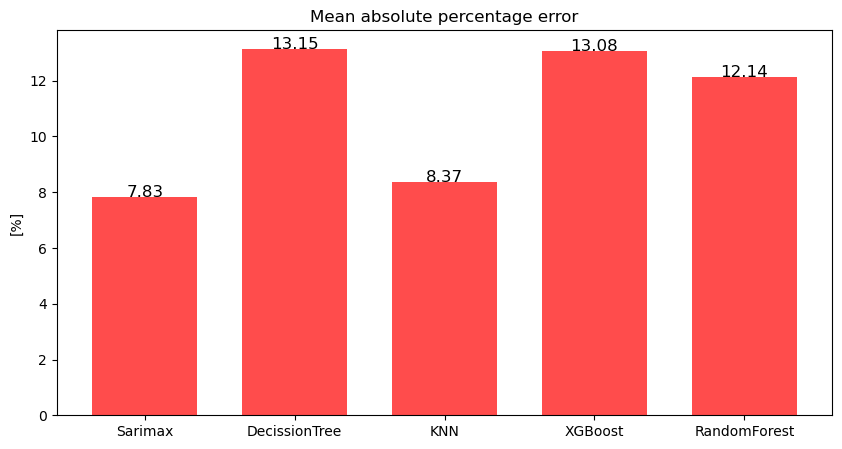

In [134]:
data = {'Sarimax':Sarimax_, 'DecissionTree':DecissionTree_, 'KNN':KNN_,'XGBoost':XGBoost_, 'RandomForest':RandomForest_ }
model = list(data.keys())
values = list(data.values())

def addlabels(model,values):
    for i in range(len(model)):
        plt.text(i, values[i], values[i], ha = 'center', size=12)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(model, values, color ='red',width = 0.7, alpha=0.7)
addlabels(model,values)
plt.ylabel("[%]")
plt.title("Mean absolute percentage error")
plt.show()